# HR Analytics: Employee Retention

Goals of this mini project:

1. to investigate what reasons potentially made the employees of a company leave their jobs in the past;
2. to build a model that can accurately predict when other employees are about to leave the company due to dissatisfaction.

Needless to say that this kind of information can be very useful for any company, since it helps spotting management deficiencies and avoiding expenses related to employee turnover, among other benefits.

For this task, a data set containing information about ~15000 employees was used. Different learning algorithms are applied to build the predictive models, and their results are evaluated in terms of sensibility, specificity and the area under the Receiver Operating Characteristic (ROC) curve.

In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))

## 1 Data load

In [2]:
# The data set is in CSV format.
df <- read.csv('raw_data.csv')

In [3]:
# Get the size of the data set.
dim(df)

[1] 14999    12

In [4]:
# Basic description.
str(df)

'data.frame':	14999 obs. of  12 variables:
 $ name                  : Factor w/ 14999 levels "AARON","ABAD",..: 12684 6923 14613 1753 6933 9378 3296 4951 11577 14631 ...
 $ satisfaction_level    : num  0.38 0.8 0.11 0.72 0.37 0.41 0.1 0.92 0.89 0.42 ...
 $ last_evaluation       : num  0.53 0.86 0.88 0.87 0.52 0.5 0.77 0.85 1 0.53 ...
 $ number_projects       : int  2 5 7 5 2 2 6 5 5 2 ...
 $ average_monthly_hours : int  157 262 272 223 159 153 247 259 224 142 ...
 $ time_spent_company    : int  3 6 4 5 3 3 4 5 5 3 ...
 $ work_accident         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ left                  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ promotion_last_5_years: int  0 0 0 0 0 0 0 0 0 0 ...
 $ department            : Factor w/ 10 levels "accounting","hr",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ salary                : Factor w/ 3 levels "high","low","medium": 2 3 3 2 2 2 2 2 2 2 ...
 $ salary_level          : int  1 2 2 1 1 1 1 1 1 1 ...


In [5]:
# Min, max, mean, median, quartiles and frequencies.
summary(df)

      name       satisfaction_level last_evaluation  number_projects
 AARON  :    1   Min.   :0.0900     Min.   :0.3600   Min.   :2.000  
 ABAD   :    1   1st Qu.:0.4400     1st Qu.:0.5600   1st Qu.:3.000  
 ABALOS :    1   Median :0.6400     Median :0.7200   Median :4.000  
 ABARCA :    1   Mean   :0.6128     Mean   :0.7161   Mean   :3.803  
 ABATE  :    1   3rd Qu.:0.8200     3rd Qu.:0.8700   3rd Qu.:5.000  
 ABBAS  :    1   Max.   :1.0000     Max.   :1.0000   Max.   :7.000  
 (Other):14993                                                      
 average_monthly_hours time_spent_company work_accident         left       
 Min.   : 96.0         Min.   : 2.000     Min.   :0.0000   Min.   :0.0000  
 1st Qu.:156.0         1st Qu.: 3.000     1st Qu.:0.0000   1st Qu.:0.0000  
 Median :200.0         Median : 3.000     Median :0.0000   Median :0.0000  
 Mean   :201.1         Mean   : 3.498     Mean   :0.1446   Mean   :0.2381  
 3rd Qu.:245.0         3rd Qu.: 4.000     3rd Qu.:0.0000   3rd Qu.:0

In [6]:
# Count missing values.
sapply(df, function(x) { sum(is.na(x)) })

name     satisfaction_level        last_evaluation 
                     0                      0                      0 
       number_projects  average_monthly_hours     time_spent_company 
                     0                      0                      0 
         work_accident                   left promotion_last_5_years 
                     0                      0                      0 
            department                 salary           salary_level 
                     0                      0                      0

In [7]:
# First 5 observations.
head(df)

name,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,time_spent_company,work_accident,left,promotion_last_5_years,department,salary,salary_level
SMITH,0.38,0.53,2,157,3,0,1,0,sales,low,1
JOHNSON,0.80,0.86,5,262,6,0,1,0,sales,medium,2
WILLIAMS,0.11,0.88,7,272,4,0,1,0,sales,medium,2
BROWN,0.72,0.87,5,223,5,0,1,0,sales,low,1
JONES,0.37,0.52,2,159,3,0,1,0,sales,low,1
MILLER,0.41,0.50,2,153,3,0,1,0,sales,low,1


In [8]:
# Last 5 observations.
tail(df)

,name,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,time_spent_company,work_accident,left,promotion_last_5_years,department,salary,salary_level
14994,ARTER,0.76,0.83,6,293,6,0,1,0,support,low,1
14995,WELDY,0.40,0.57,2,151,3,0,1,0,support,low,1
14996,VINTON,0.37,0.48,2,160,3,0,1,0,support,low,1
14997,SALIBA,0.37,0.53,2,143,3,0,1,0,support,low,1
14998,PARMAR,0.11,0.96,6,280,4,0,1,0,support,low,1
14999,OSTLER,0.37,0.52,2,158,3,0,1,0,support,low,1


So the data set contains exactly 14999 observations and each is described by 12 features:

* `name`: employee's last name.
* `satisfaction_level`: employee's satisfaction, as a 0-1 score.
* `last_evaluation`: employee's score in the last evaluation, as a 0-1 score.
* `number_projects`: number of projects the employee has worked on.
* `average_monthly_hours`: average working hours per month.
* `time_spent_company`: how long (years) the employee works at the company.
* `work_accident`: values 1 if the employee has had any work accident, and 0 otherwise.
* `left`: values 1 if the employee has left the company, and 0 otherwise.
* `promotion_last_5_years`: values 1 if the employee has received a promotion in the last 5 years, and 0 otherwise.
* `department`: department the employee works in.
* `salary`: employee's salary level ("low", "medium", "high").
* `salary_level`: employee's salary level as a number (1, 2, 3).

There are no missing values to be filled.

`left` is the target variable.

In [9]:
# Represent categorical features as factors.
df <- df %>%
    mutate(work_accident = as.factor(work_accident)) %>%
    mutate(left = as.factor(left)) %>%
    mutate(promotion_last_5_years = as.factor(promotion_last_5_years)) %>%
    mutate(salary = factor(salary, levels = c('low', 'medium', 'high'), ordered = T))

In [10]:
# Drop useless features.
df <- subset(df, select = -c(name, salary_level))

In [11]:
str(df)

'data.frame':	14999 obs. of  10 variables:
 $ satisfaction_level    : num  0.38 0.8 0.11 0.72 0.37 0.41 0.1 0.92 0.89 0.42 ...
 $ last_evaluation       : num  0.53 0.86 0.88 0.87 0.52 0.5 0.77 0.85 1 0.53 ...
 $ number_projects       : int  2 5 7 5 2 2 6 5 5 2 ...
 $ average_monthly_hours : int  157 262 272 223 159 153 247 259 224 142 ...
 $ time_spent_company    : int  3 6 4 5 3 3 4 5 5 3 ...
 $ work_accident         : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ left                  : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ promotion_last_5_years: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ department            : Factor w/ 10 levels "accounting","hr",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ salary                : Ord.factor w/ 3 levels "low"<"medium"<..: 1 2 2 1 1 1 1 1 1 1 ...


## 2 Exploratory data analysis

In [12]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
# Source: http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)
#
multiplot <- function(..., plotlist = NULL, file, cols = 1, layout = NULL) {
    library(grid)

    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)

    numPlots = length(plots)

    # If layout is NULL, then use 'cols' to determine layout
    if (is.null(layout)) {
        # Make the panel
        # ncol: Number of columns of plots
        # nrow: Number of rows needed, calculated from # of cols
        layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                         ncol = cols, nrow = ceiling(numPlots/cols))
    }

    if (numPlots == 1) {
        print(plots[[1]])
    } else {
        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            # Get the i,j matrix positions of the regions that contain this subplot
            matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

            print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                            layout.pos.col = matchidx$col))
        }
    }
}

In [13]:
# Feature names.
names.categorical <- c('work_accident', 'promotion_last_5_years', 'department', 'salary')
names.numerical <- c('satisfaction_level', 'last_evaluation', 'number_projects', 'average_monthly_hours', 'time_spent_company')

### 2.1 Marginal feature distributions

#### `left`

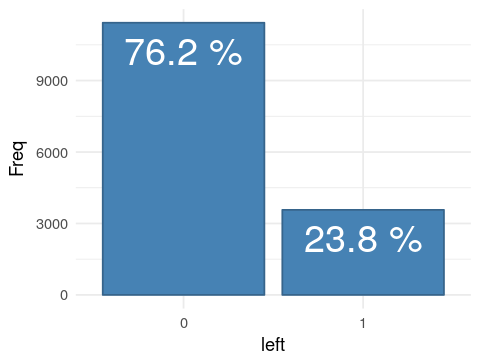

In [14]:
options(repr.plot.width = 4, repr.plot.height = 3)

df.left <- as.data.frame(table(df$left))
df.left <- mutate(df.left, left = Var1, Prop = Freq / sum(Freq))

ggplot(df.left, aes(x = left, y = Freq)) +
    geom_bar(stat = 'identity', colour = 'steelblue4', fill = 'steelblue') +
    geom_text(aes(label = paste(100 * round(Prop, 3), '%')),
              vjust = 1.5, size = 8, colour = 'white') +
    theme_minimal()

#### Continuous features

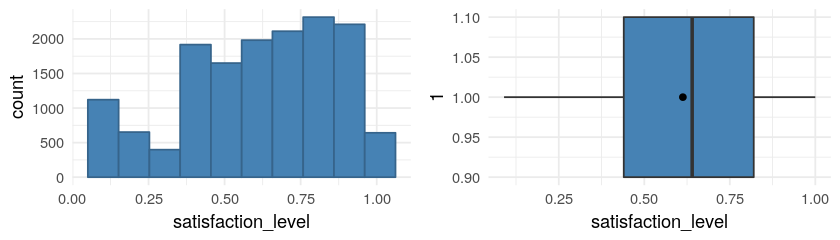

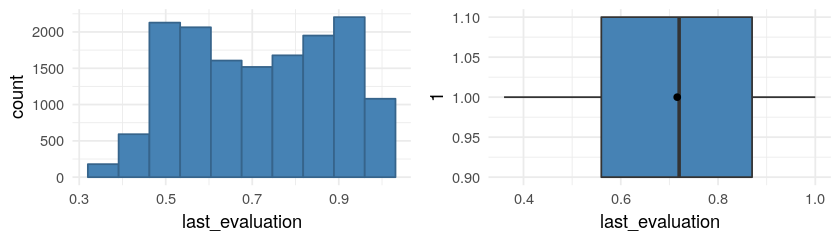

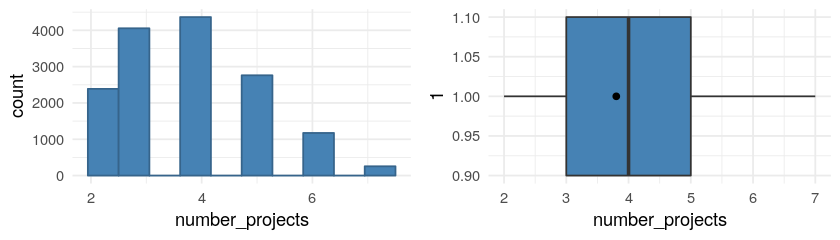

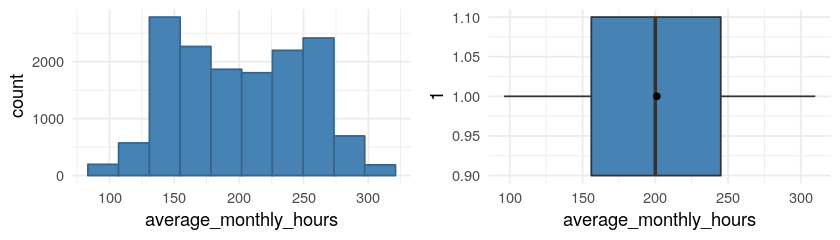

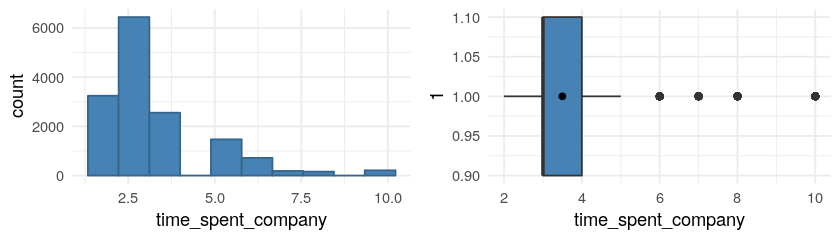

In [15]:
options(repr.plot.width = 7, repr.plot.height = 2)

for (x in names.numerical) {
    g1 <- ggplot(df, aes_string(x = x)) +
        geom_histogram(bins = 10, colour = 'steelblue4', fill = 'steelblue') +
        theme_minimal()

    g2 <- ggplot(df, aes_string(x = '1', y = x)) +
        geom_boxplot(fill = 'steelblue', width = 0.2) +
        stat_summary(fun.y = mean, geom = 'point') +
        coord_flip() +
        theme_minimal()

    multiplot(g1, g2, cols = 2)
}

Some conclusions and further questions:

* The satisfaction levels are slightly skewed in favour of higher values, with the mean around 0.6. 
* There are employees that work too much, but others work less than average. How does that relate to the employee dissatisfaction?
* Only a few employees stay in the company for more than 4 years. Most leave earlier.

#### Categorical features

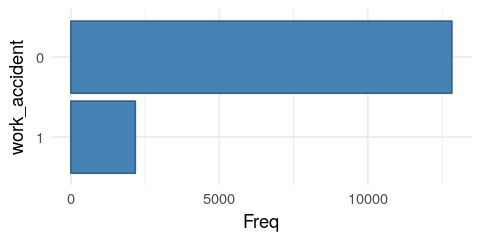

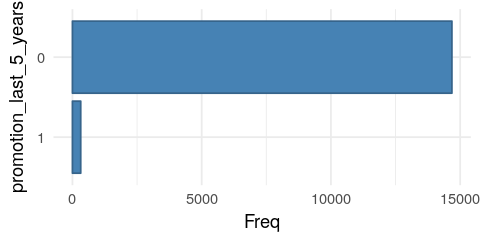

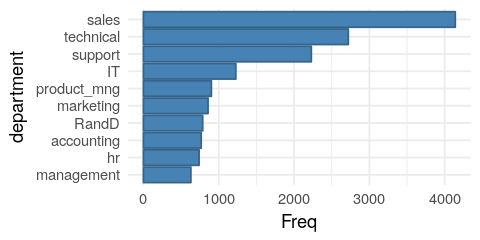

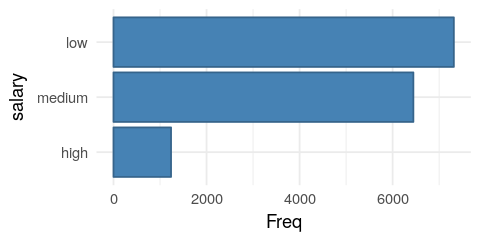

In [16]:
options(repr.plot.width = 4, repr.plot.height = 2)

for (x in names.categorical) {
    df.x <- as.data.frame(table(df[, x]))
    df.x <- mutate(df.x, Var1 = reorder(Var1, Freq))
    colnames(df.x) <- c(x, 'Freq')
    
    g <- ggplot(df.x, aes_string(x = x, y = 'Freq')) +
        geom_bar(stat = 'identity', colour = 'steelblue4', fill = 'steelblue') +
        coord_flip() +
        theme_minimal()

    print(g)
}

Some conclusions and further questions:

* Very few employees have received a promotion in the last 5 years. Could this lack of recognition be one of the main reasons that make employees leave the company?
* Sales, technical and support are the departments with more employees. Were the people that left the company mostly in these departments too?
* Most employees receive a low salary.

### 2.2 Joint feature distributions

### 2.3 Feature correlations

In [17]:
# Multiple correlation test function.
#
# Computes tests for association/correlation between paired samples
# represented in the rows and columns of a matrix.
#
# Source: https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html
#
cor.mtest <- function(mat, conf.level = 0.95){
  mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- lowCI.mat <- uppCI.mat <- matrix(NA, n, n)
    diag(p.mat) <- 0
    diag(lowCI.mat) <- diag(uppCI.mat) <- 1
    for(i in 1:(n-1)){
        for(j in (i+1):n){
            tmp <- cor.test(mat[,i], mat[,j], conf.level = conf.level)
            p.mat[i,j] <- p.mat[j,i] <- tmp$p.value
            lowCI.mat[i,j] <- lowCI.mat[j,i] <- tmp$conf.int[1]
            uppCI.mat[i,j] <- uppCI.mat[j,i] <- tmp$conf.int[2]
        }
    }
    return(list(p.mat, lowCI.mat, uppCI.mat))
}

## 3 Preprocessing

## 4 Model training

## 5 Results